In [1]:
#!pip install nibabel
#!pip install matplotlib
#!pip install opencv-python
#!pip install torch
#!pip install segmentation-models-3D
#!pip install classification-models-3D
#!pip install efficientnet-3D
#!pip install keras_applications
#!pip install scikit-image
#!pip install patchify

In [2]:
import numpy as np
import pandas as pd
import sys, os, glob
import math, random
import tensorflow as tf
from matplotlib import pyplot as plt
import random
import keras

print(tf.__version__)
print(keras.__version__)

import segmentation_models_3D as sm

sys.path.append('/path/to/2014_07_13_test')
import generate_input

2.9.0
2.9.0
Segmentation Models: using `keras` framework.


In [3]:
import nibabel as nib
from matplotlib import pyplot as plt

import torch

import keras
from keras.models import load_model
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda, LeakyReLU
from keras.optimizers import Adam
from keras.metrics import MeanIoU

from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

import segmentation_models_3D as sm


(27, 128, 128)
[0. 1. 2. 3.]


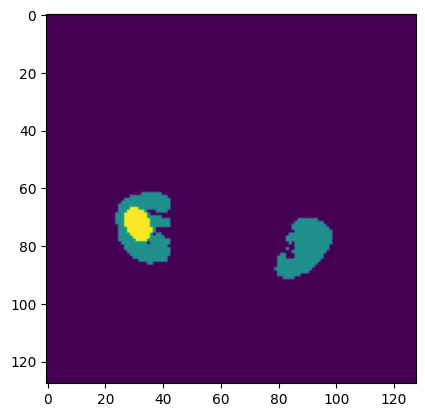

In [4]:
ct_nii = np.load('./preprocessed-data/masks/case_00179.npy')
print(ct_nii.shape)
print(np.unique(ct_nii))
test = ct_nii[12,:,:]
plt.imshow(test)

In [5]:
# load validation set
val_case = ['case_00233', 'case_00089', 'case_00050', 'case_00112', 'case_00258', 'case_00246', 'case_00157',
            'case_00149','case_00184']
test_case = ['case_00221', 'case_00259', 'case_00087', 'case_00254', 'case_00098', 'case_00023', 'case_00041',
             'case_00080', 'case_00101', 'case_00164', 'case_00002', 'case_00110', 'case_00030', 'case_00068',
             'case_00026', 'case_00063', 'case_00006', 'case_00048', 'case_00250', 'case_00238', 'case_00015',
             'case_00111', 'case_00278', 'case_00133', 'case_00284', 'case_00282', 'case_00269', 'case_00039',
             'case_00033', 'case_00108', 'case_00175', 'case_00161', 'case_00256', 'case_00119', 'case_00286',
             'case_00077', 'case_00162', 'case_00270', 'case_00271', 'case_00285', 'case_00174', 'case_00147',
             'case_00215', 'case_00150', 'case_00052', 'case_00231', 'case_00198', 'case_00117', 'case_00138',
             'case_00211', 'case_00190', 'case_00248', 'case_00235', 'case_00049', 'case_00074', 'case_00107',
             'case_00218', 'case_00001', 'case_00193', 'case_00067', 'case_00289', 'case_00072', 'case_00044',
             'case_00294', 'case_00298', 'case_00263', 'case_00038', 'case_00299', 'case_00249', 'case_00225',
             'case_00217', 'case_00178', 'case_00082', 'case_00035', 'case_00034', 'case_00047', 'case_00276',
             'case_00151', 'case_00226', 'case_00086', 'case_00176']

all_cases = [ 'case_' + str(number).zfill(5) for number in range(300)] # create list of all cases
train_case = [x for x in all_cases if x not in val_case and x not in test_case] # take only cases not in test and val


In [6]:
print(len(val_case), len(test_case), len(train_case), len(all_cases))

9 81 210 300


## Load data

In [7]:
#def fill_3D_set_old(case_ids, image_dictionary, mask_dictionary):
#    img_list, mask_list = [], []
    
#    for idx, c in enumerate(case_ids):
#        img_list.append(np.expand_dims(image_dictionary[c].T, axis=0).T)
#        mask_list.append(np.expand_dims(mask_dictionary[c].T, axis=0).T)
        
#        x_array, y_array = np.asarray(img_list).astype(np.float64), np.asarray(mask_list).astype(np.float64)
#        print(c, x_array.shape, y_array.shape)
        
#    return x_array, y_array

def fill_3D_set(case_ids, image_dictionary, mask_dictionary):
    img_list, mask_list = [], []
    
    for idx, c in enumerate(case_ids):
        img_list.append(image_dictionary[c])
        mask_list.append(mask_dictionary[c])
        
    x_array, y_array = np.asarray(img_list).astype(np.float64), np.asarray(mask_list).astype(np.float64)
    x_array, y_array = np.expand_dims(x_array.T, axis=0).T, np.expand_dims(y_array.T, axis=0).T
    print(c, x_array.shape, y_array.shape)
        
    return x_array, y_array

In [8]:
def crop_image_stack(img_dict, mask_dict, num_slices):
    
    for case_id in img_dict.keys():
        stack_size = img_dict[case_id].shape[0]
        bot_slice, top_slice = math.ceil((stack_size/2)-(num_slices/2)), math.ceil((stack_size/2)+(num_slices/2))
        #print(stack_size, bot_slice, top_slice)
        img_dict[case_id] = img_dict[case_id][bot_slice:top_slice, :, :]
        mask_dict[case_id] = mask_dict[case_id][bot_slice:top_slice, :, :]
        
    return img_dict, mask_dict

In [9]:
def resize_image_stack_and_flip(img_dict, mask_dict):
    
    for case_id in img_dict.keys():
    
        diff = img_dict[case_id].shape[1] - img_dict[case_id].shape[0]
        l, h = math.ceil(diff/2), math.floor(diff/2)

        if h==0:
            print('yo', case_id, img_dict[case_id].shape, mask_dict[case_id].shape)
            empty_array = np.zeros([img_dict[case_id].shape[1], img_dict[case_id].shape[2]])
            front_padding = np.array([empty_array]*l)
            resized_img = np.concatenate((front_padding, img_dict[case_id]))
            resized_mask = np.concatenate((front_padding, mask_dict[case_id]))
            
        elif img_dict[case_id].shape[0] < img_dict[case_id].shape[1]:
            #print('padding image stack from {0} to {1}'.format(img_dict[case_id].shape[0], img_dict[case_id].shape[1]))
            empty_array = np.zeros([img_dict[case_id].shape[1], img_dict[case_id].shape[2]])
            front_padding, back_padding = np.array([empty_array]*l), np.array([empty_array]*h)
            resized_img = np.concatenate((front_padding, img_dict[case_id]))
            resized_img = np.concatenate((resized_img,back_padding))
            resized_mask = np.concatenate((front_padding, mask_dict[case_id]))
            resized_mask = np.concatenate((resized_mask,back_padding))
        
        elif img_dict[case_id].shape[0] >= img_dict[case_id].shape[1]:
            resized_img = img_dict[case_id][-l:h].copy()
            resized_mask = mask_dict[case_id][-l:h].copy()

        img_dict[case_id] = resized_img
        mask_dict[case_id] = resized_mask
        
    return img_dict, mask_dict

# DATA PREPARATION

In [10]:
json_path = '../kits21/kits21/data/kits.json'
n_samples = 300
neg_pct = 100
rootdir = './preprocessed-data/'
img_dir = 'images'
mask_dir = 'masks'
val_split = 25
test_split = 25

#------------- Generate dictionary of case_id and binary malignant label --------
labels_dict = generate_input.malignant_labels_to_dict(json_path)
print('Number of labels in labels_dict: ', len(labels_dict))

#------------- Sample n instances from labels_dict with all possible negative cases --------
subsample_list = generate_input.generate_subsample_id_list(n_samples, neg_pct, labels_dict)

#------------- Generate list of paths to preprocessed images --------

image_paths_list = generate_input.processed_image_paths(rootdir, img_dir)
mask_paths_list = generate_input.processed_image_paths(rootdir, mask_dir)
print('Are image and mask path list the same lenght?: ', len(image_paths_list) == len(mask_paths_list))

#------------- Load images and masks filtered by subsample --------
image_dict = generate_input.load_nifti_img_and_mask_as_numpy(image_paths_list, subsample_list)
mask_dict = generate_input.load_nifti_img_and_mask_as_numpy(mask_paths_list, subsample_list)
print('Are image and mask dictionaries the same lenght?:', len(image_dict) == len(mask_dict))

#image_dict, mask_dict = crop_image_stack(image_dict, mask_dict, 20)

image_dict, mask_dict = resize_image_stack_and_flip(image_dict, mask_dict)
print('resized images and masks:', image_dict[subsample_list[0]].shape, mask_dict[subsample_list[0]].shape)

#--------------- flatten case and labels dictionary for split ---------------
#cases = subsample_list
#labels = [labels_dict[x] for x in cases]
#print("Are cases and labels lists the same length?: ", len(cases) == len(labels), len(cases), len(labels))

#--------------- split training, validation and test set on patient/case level ---------------
#id_train, labels_train, id_val, labels_val, id_test, labels_test = generate_input.split_sets(cases, labels, val_split, test_split)

#x_train, mask_train = fill_3D_set(id_train, image_dict, mask_dict)
#x_val, mask_val = fill_3D_set(id_val, image_dict, mask_dict)
#x_test, mask_test = fill_3D_set(id_test, image_dict, mask_dict)
    
#print("Are training set and labels lists the same length?: ", len(x_train) == len(mask_train), len(x_train), len(mask_train))
#print("Are training imageas and masks same length?: ", len(mask_train) == len(x_train), len(mask_train), len(x_train))

Number of labels in labels_dict:  300
Generated list of 300 case IDs of 275 positive and 25 negative labels
Are image and mask path list the same lenght?:  True
Are image and mask dictionaries the same lenght?: True
yo case_00213 (127, 128, 128) (127, 128, 128)
resized images and masks: (128, 128, 128) (128, 128, 128)


In [11]:
x_test, mask_test = fill_3D_set(test_case, image_dict, mask_dict)
x_all, mask_all = fill_3D_set(all_cases, image_dict, mask_dict)

case_00176 (81, 128, 128, 128, 1) (81, 128, 128, 128, 1)
case_00299 (300, 128, 128, 128, 1) (300, 128, 128, 128, 1)


In [12]:
print(mask_all.shape, x_all.shape, len(image_dict), len(mask_dict))

(300, 128, 128, 128, 1) (300, 128, 128, 128, 1) 300 300


In [13]:
print(type(x_test), x_test.shape, type(mask_test),  mask_test.shape, mask_test[0].shape)
print(np.unique(mask_test[0]), mask_test.shape)

<class 'numpy.ndarray'> (81, 128, 128, 128, 1) <class 'numpy.ndarray'> (81, 128, 128, 128, 1) (128, 128, 128, 1)
[0. 1. 2.] (81, 128, 128, 128, 1)


In [14]:
mask_test = np.where(mask_test > 0.0, 1, 0)
mask_all = np.where(mask_all > 0.0, 1, 0)

print(mask_all[0][0][0][0][0], type(mask_all[0][0][0][0][0]), np.unique(mask_all))
print(mask_test[0][0][0][0][0], type(mask_test[0][0][0][0][0]), np.unique(mask_test))

0 <class 'numpy.int64'> [0 1]
0 <class 'numpy.int64'> [0 1]


In [15]:
#test = x_test[5][64,:,:]
#plt.imshow(test)

[0 1]


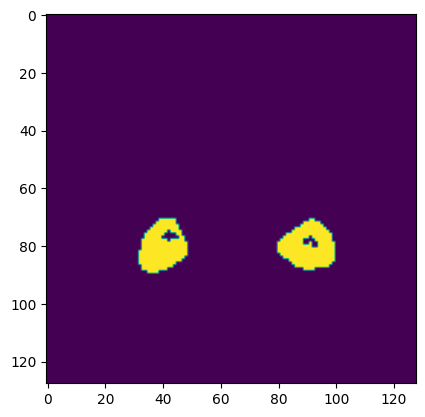

In [16]:
test = mask_test[5][64,:,:]
plt.imshow(test)
print(np.unique(test))

(81, 128, 128, 128, 1)
(81, 128, 128, 128, 1)
Metal device set to: Apple M1


2023-05-09 08:03:34.581963: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-09 08:03:34.582811: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


(81, 128, 128, 128, 1) (81, 128, 128, 128, 1)


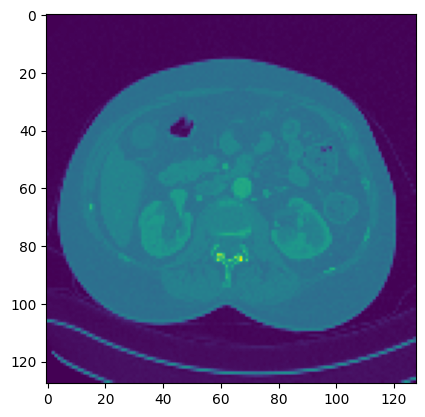

In [17]:
print(mask_test.shape)

#x_train, mask_train = torch.from_numpy(x_train), torch.from_numpy(mask_train[:,:,:,:,0].astype(int))
#x_val, mask_val = torch.from_numpy(x_val), torch.from_numpy(mask_val[:,:,:,:,0].astype(int))
#x_test, mask_test = torch.from_numpy(x_test), torch.from_numpy(mask_test[:,:,:,:,0].astype(int))

print(mask_test.shape)

#one hot encoding of index category masks to create binary channel for each class (background, kdiney, cyst, tumor) 
#mask_train, mask_val, mask_test = torch.nn.functional.one_hot(mask_train), torch.nn.functional.one_hot(mask_val), torch.nn.functional.one_hot(mask_test)

x_all, mask_all = tf.convert_to_tensor(x_all, dtype=float), tf.convert_to_tensor(mask_all, dtype=float)
x_test, mask_test = tf.convert_to_tensor(x_test, dtype=float), tf.convert_to_tensor(mask_test, dtype=float)

#x_train, mask_train = tf.cast(x_train, tf.float32), tf.cast(mask_train, tf.float32)
#x_val, mask_val = tf.cast(x_val, tf.float32), tf.cast(mask_val, tf.float32)
#x_test, mask_test = tf.cast(x_test, tf.float32), tf.cast(mask_test, tf.float32)

print(x_test.shape, mask_test.shape)
plt.imshow(x_test[4][64,:,:])

# Load model

In [313]:
my_model = load_model('segBinary_final.hdf5', compile=False)

# Predict masks from loaded model, test set validation

In [314]:
#predict masks
predictions_output = my_model.predict(x_test, batch_size=2, verbose=1)


2023-05-10 10:52:44.774095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 134s 3s/step


In [315]:
print(len(predictions_output), len(mask_test), type(predictions_output))

81 81 <class 'numpy.ndarray'>


In [316]:
from keras import backend as K

def dice_coef(y_true, y_pred):
    smooth = 0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


dice_scores, dice_sum = [], 0

for i in range (len(predictions_output)):
    dice = dice_coef(mask_test[i], predictions_output[i])
    dice_sum += dice.numpy()
    dice_scores.append(np.round(dice.numpy(), 4))

mean_test_dice = sum(dice_scores)/len(dice_scores)

print('individual dice scores: ', dice_scores)
print('mean dice score: ', mean_test_dice)

individual dice scores:  [0.6702, 0.5996, 0.7935, 0.8429, 0.7911, 0.6027, 0.7429, 0.6749, 0.9222, 0.7727, 0.6293, 0.5997, 0.452, 0.8254, 0.8386, 0.8789, 0.6689, 0.4811, 0.6944, 0.7351, 0.2717, 0.6166, 0.5914, 0.5017, 0.7747, 0.7161, 0.6888, 0.6611, 0.8217, 0.8247, 0.6554, 0.6744, 0.4743, 0.5194, 0.5945, 0.6016, 0.5582, 0.5515, 0.6895, 0.7184, 0.6657, 0.7416, 0.6686, 0.6258, 0.8215, 0.8503, 0.7785, 0.5885, 0.6958, 0.6195, 0.8152, 0.7057, 0.8238, 0.8655, 0.5624, 0.5361, 0.8219, 0.8071, 0.5734, 0.5472, 0.7115, 0.7463, 0.8239, 0.6277, 0.8782, 0.8077, 0.8177, 0.8742, 0.847, 0.6958, 0.5969, 0.6444, 0.6911, 0.7206, 0.7965, 0.6812, 0.8669, 0.4226, 0.8319, 0.5397, 0.6672]
mean dice score:  0.6928999979554871


0.8782 0.8789 0.9222


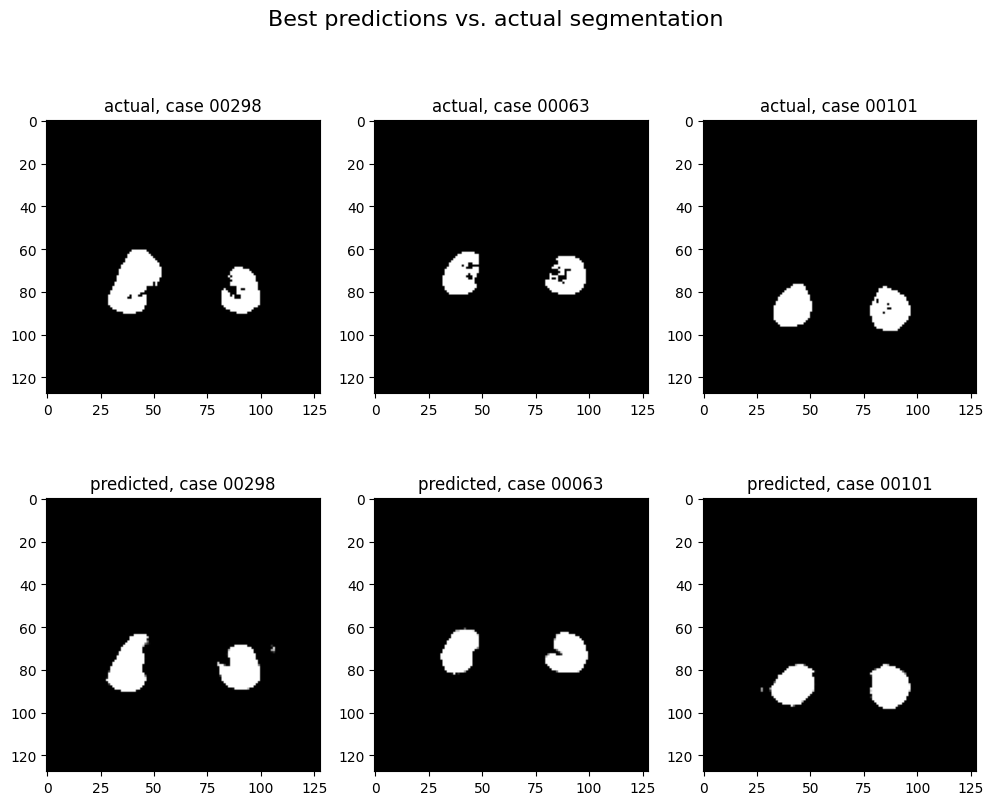

In [317]:
n_img = 7
#n_slice = 64
#case = test_case[n_img]
#pred_dice = dice_scores[n_img]
#print(pred_dice)
N = 3
res = sorted(range(len(dice_scores)), key = lambda sub: dice_scores[sub])[-3:]
print(dice_scores[res[0]], dice_scores[res[1]], dice_scores[res[2]])
images, scores, cases = [], [], []

images.append(mask_test[res[0]][64,:,:])
images.append(mask_test[res[1]][64,:,:])
images.append(mask_test[res[2]][64,:,:])
cases.append(test_case[res[0]][-5:]), cases.append(test_case[res[1]][-5:]), cases.append(test_case[res[2]][-5:])


images.append(predictions_output[res[0]][64,:,:])
images.append(predictions_output[res[1]][64,:,:])
images.append(predictions_output[res[2]][64,:,:])

# Define a figure of size (12, 12)
fig = plt.figure(figsize=(12, 9))

# Define row and cols in the figure
rows, cols = 2, 3

titles = ['actual, case {0}'.format(cases[0]), 'actual, case {0}'.format(cases[1]), 'actual, case {0}'.format(cases[2]), 
          'predicted, case {0}'.format(cases[0]), 'predicted, case {0}'.format(cases[1]), 'predicted, case {0}'.format(cases[2])]
# Display first four images
for j in range(0, cols*rows):
    fig.add_subplot(rows, cols, j+1)
    plt.title(titles[j])
    plt.imshow(images[j], cmap='gray')

fig.suptitle('Best predictions vs. actual segmentation', fontsize=16)
plt.show()

0.2717 0.4226 0.452


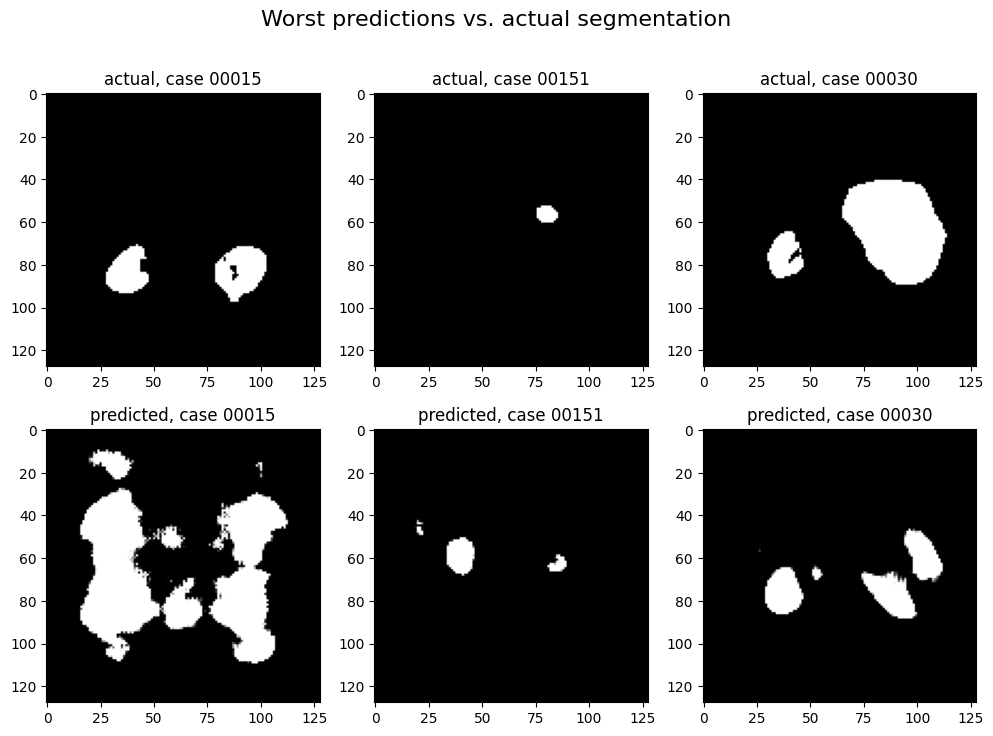

In [318]:
n_slice = 64
N = 3
res = sorted(range(len(dice_scores)), key = lambda sub: dice_scores[sub])[:3]
print(dice_scores[res[0]], dice_scores[res[1]], dice_scores[res[2]])
images, scores, cases = [], [], []

images.append(mask_test[res[0]][n_slice,:,:])
images.append(mask_test[res[1]][n_slice,:,:])
images.append(mask_test[res[2]][n_slice,:,:])
cases.append(test_case[res[0]][-5:]), cases.append(test_case[res[1]][-5:]), cases.append(test_case[res[2]][-5:])


images.append(predictions_output[res[0]][n_slice,:,:])
images.append(predictions_output[res[1]][n_slice,:,:])
images.append(predictions_output[res[2]][n_slice,:,:])


#images = [test_binary, pred_binary]
#scores = [score_1]
# Define a figure of size (12, 12)
fig = plt.figure(figsize=(12, 8))

# Define row and cols in the figure
rows, cols = 2, 3

titles = ['actual, case {0}'.format(cases[0]), 'actual, case {0}'.format(cases[1]), 'actual, case {0}'.format(cases[2]), 
          'predicted, case {0}'.format(cases[0]), 'predicted, case {0}'.format(cases[1]), 'predicted, case {0}'.format(cases[2])]
# Display first four images
for j in range(0, cols*rows):
    fig.add_subplot(rows, cols, j+1)
    plt.title(titles[j])
    plt.imshow(images[j], cmap='gray')

fig.suptitle('Worst predictions vs. actual segmentation', fontsize=16)
plt.show()

## Crop masks and images

In [319]:
import cv2

# cropping images
predicted_masks = predictions_output.copy()
images = np.array(x_test)

cropped_predictions, cropped_images = [], []

for i in range(len(predicted_masks)):
    msk = np.round(predicted_masks[i])
    img = images[i]
    msk_mid = msk[msk.shape[0]//2, :, :]
    size = msk.shape[1]//2
    padding = math.ceil(size*0.2)
    
    res = np.argwhere(msk_mid > 0.0) #find where there are kidney/renal mass  
    max_res, min_res = np.max(res, axis=0), np.min(res, axis=0) #find minimum and maximum corrdinates
    diff_y, diff_x = (size-(max_res[0]-min_res[0]))//2, (size-(max_res[1]-min_res[1]+1))//2 #find difference from wanted img size (64)
    y_min, y_max = min_res[0]-diff_y, max_res[0]+diff_y+1
    x_min, x_max = min_res[1]-math.floor(diff_x), max_res[1]+math.ceil(diff_x)+1 #min_res[1]-math.floor(diff_x//2)-1, max_res[1]+math.ceil(diff_x//2)
    
    #print('min:', min_res, 'max:', max_res)
    #print('x:', x_min, x_max, x_max-x_min, diff_x*2, 'y:', y_min, y_max, diff_y)
    
    
    cropped_msk_lst, cropped_img_lst = [], []
    
    for j in range(msk.shape[0]):
        
        if (diff_x < 0) or (diff_y < 0):
            cropped_msk = msk[j][y_min-padding:y_max+padding, x_min-padding:x_max+padding]
            cropped_img = img[j][y_min-padding:y_max+padding, x_min-padding: x_max+padding]
        
        else:
            cropped_msk = msk[j][y_min-padding:y_max+padding, x_min-padding:x_max+padding]
            cropped_img = img[j][y_min-padding:y_max+padding, x_min-padding:x_max+padding]
        
        cropped_msk = cv2.resize(cropped_msk, dsize=(size, size), interpolation=cv2.INTER_NEAREST)
        cropped_img = cv2.resize(cropped_img, dsize=(size, size), interpolation=cv2.INTER_NEAREST)
        cropped_msk_lst.append(cropped_msk), cropped_img_lst.append(cropped_img)

    #np.save('./cropped-data/masks-64/' + test_case[i] +'.npy', np.array(cropped_msk))
    #np.save('./cropped-data/images-64/' + test_case[i] +'.npy', np.array(cropped_img))

    
    cropped_predictions.append(np.expand_dims(np.array(cropped_msk_lst).T, axis=0).T)
    cropped_images.append(np.array(cropped_img_lst))

print(cropped_predictions[0].shape, cropped_images[0].shape)


(128, 64, 64, 1) (128, 64, 64)


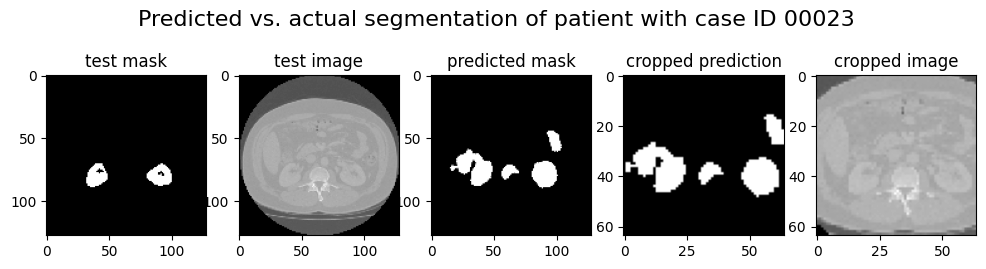

In [320]:
n_img = 5
n_slice = 64
case = test_case[n_img]

pred_cropped = cropped_predictions[n_img][n_slice,:,:]
cropped_img = cropped_images[n_img][n_slice,:,:]
pred_mask = predictions_output[n_img][n_slice,:,:]
test_img = x_test[n_img][n_slice,:,:]
test_mask =  mask_test[n_img][n_slice,:,:]

images = [test_mask, test_img, pred_mask, pred_cropped, cropped_img]


fig = plt.figure(figsize=(12, 3))

# Define row and cols in the figure
rows, cols = 1, 5

titles = ['test mask', 'test image', 'predicted mask', 'cropped prediction', 'cropped image']
#titles = ['Cropped pred', 'Cropped img', 'test mask', 'test image']
# Display first four images
for j in range(0, cols*rows):
    fig.add_subplot(rows, cols, j+1)
    plt.title(titles[j])
    plt.imshow(images[j], cmap='gray')

fig.suptitle('Predicted vs. actual segmentation of patient with case ID {0}'.format(case[-5:]), fontsize=16)
plt.show()

# Predict from loaded model, on all data, crop data

In [321]:
#predict masks
predictions_output_all = my_model.predict(x_all, batch_size = 2, verbose=1)

150/150 [==============================] - 528s 4s/step


In [322]:
dice_scores_all, dice_sum_all = [], 0

print(type(mask_all), mask_all.shape, type(predictions_output_all), predictions_output_all.shape)

for i in range (len(predictions_output_all)):
    dice = dice_coef(mask_all[i], predictions_output_all[i])
    dice_sum += dice.numpy()
    dice_scores_all.append(np.round(dice.numpy(), 4))

mean_test_dice_all = sum(dice_scores)/len(dice_scores)

print('individual dice scores: ', dice_scores_all)
print('mean dice score: ', mean_test_dice_all)

<class 'tensorflow.python.framework.ops.EagerTensor'> (300, 128, 128, 128, 1) <class 'numpy.ndarray'> (300, 128, 128, 128, 1)
individual dice scores:  [0.8882, 0.8071, 0.6293, 0.7428, 0.8225, 0.8228, 0.6689, 0.7668, 0.7709, 0.7577, 0.7761, 0.7121, 0.6665, 0.7841, 0.7928, 0.2717, 0.8921, 0.684, 0.691, 0.679, 0.81, 0.6993, 0.8397, 0.6027, 0.7674, 0.7494, 0.8386, 0.9233, 0.7442, 0.674, 0.452, 0.6214, 0.6547, 0.8217, 0.7965, 0.7206, 0.9012, 0.7614, 0.8177, 0.6611, 0.5245, 0.7429, 0.8926, 0.6293, 0.8239, 0.5725, 0.7797, 0.6812, 0.4811, 0.8655, 0.6286, 0.8811, 0.8215, 0.8846, 0.7773, 0.7234, 0.7937, 0.8014, 0.8258, 0.8322, 0.7165, 0.5739, 0.7531, 0.8789, 0.5866, 0.6421, 0.6525, 0.5472, 0.8254, 0.7639, 0.793, 0.8706, 0.7463, 0.8305, 0.5624, 0.7393, 0.7669, 0.6016, 0.8514, 0.7848, 0.6749, 0.6457, 0.6911, 0.7967, 0.7651, 0.5784, 0.5397, 0.7935, 0.7124, 0.6444, 0.8482, 0.8589, 0.81, 0.8929, 0.5893, 0.8334, 0.8852, 0.6889, 0.7911, 0.6088, 0.8349, 0.9222, 0.8549, 0.8559, 0.7574, 0.7809, 0.7115, 0.

In [323]:
res = sorted(range(len(dice_scores_all)), key = lambda sub: dice_scores_all[sub])[:3]
print(dice_scores_all[res[0]], dice_scores_all[res[1]], dice_scores_all[res[2]])
print('worst:', res)

res = sorted(range(len(dice_scores_all)), key = lambda sub: dice_scores_all[sub])[-3:]
print(dice_scores_all[res[0]], dice_scores_all[res[1]], dice_scores_all[res[2]])
print('best:', res)

0.2717 0.3604 0.4226
worst: [15, 297, 151]
0.9222 0.9224 0.9233
best: [101, 135, 27]


In [324]:
if not os.path.exists('./cropped-data'):
    os.mkdir('./cropped-data')

path_images = './cropped-data/images-64/'
if not os.path.exists(path_images):
    os.mkdir(path_images)
    
path_masks = './cropped-data/masks-64'
if not os.path.exists(path_masks):
    os.mkdir(path_masks)

In [325]:
# cropping images
predicted_masks = predictions_output_all.copy()
images = np.array(x_all)

cropped_predictions, cropped_images = [], []

for i in range(len(predicted_masks)):
    msk = np.round(predicted_masks[i])
    img = images[i]
    msk_mid = msk[msk.shape[0]//2, :, :]
    size = msk.shape[1]//2
    padding = math.ceil(size*0.2)
    
    if msk_mid.any():
        res = np.argwhere(msk_mid > 0.0) #find where there are kidney/renal mass  
        max_res, min_res = np.max(res, axis=0), np.min(res, axis=0) #find minimum and maximum corrdinates
        diff_y, diff_x = (size-(max_res[0]-min_res[0]))//2, (size-(max_res[1]-min_res[1]+1))//2 #find difference from wanted img size (64)
        y_min, y_max = min_res[0]-math.floor(diff_y), max_res[0]+math.ceil(diff_y)+1
        x_min, x_max = min_res[1]-math.floor(diff_x), max_res[1]+math.ceil(diff_x)+1 #min_res[1]-math.floor(diff_x//2)-1, max_res[1]+math.ceil(diff_x//2)
    
    
    cropped_msk_lst, cropped_img_lst = [], []
    
    for j in range(msk.shape[0]):
        
        #add margin to crop
        if diff_x < 0:
            cropped_msk = msk[j][y_min-padding:y_max+padding, x_min-padding+diff_x:x_max+padding-diff_x]
            cropped_img = img[j][y_min-padding:y_max+padding, x_min-padding+diff_x:x_max+padding-diff_x]
            
        else:
            cropped_msk = msk[j][y_min-padding:y_max+padding, x_min-padding:x_max+padding]
            cropped_img = img[j][y_min-padding:y_max+padding, x_min-padding:x_max+padding]
        
        #resize crop:
        if (not cropped_msk.any()) and (not cropped_img.any()): 
            cropped_msk = np.zeros([64,64])
            cropped_img = np.zeros([64,64])
        
        elif (not cropped_msk.any()) and cropped_img.any():
            cropped_msk = np.zeros([64,64])
            cropped_img = cv2.resize(cropped_img, dsize=(size, size), interpolation=cv2.INTER_NEAREST)
        
        elif cropped_msk.any() and (not cropped_img.any()):
            cropped_msk = cv2.resize(cropped_msk, dsize=(size, size), interpolation=cv2.INTER_NEAREST)
            cropped_img = np.zeros([64,64])
        
        else:
            cropped_msk = cv2.resize(cropped_msk, dsize=(size, size), interpolation=cv2.INTER_NEAREST)
            cropped_img = cv2.resize(cropped_img, dsize=(size, size), interpolation=cv2.INTER_NEAREST)
        
        cropped_msk_lst.append(cropped_msk), cropped_img_lst.append(cropped_img)    

        #print(all_cases[i], cropped_msk.shape, not cropped_msk.any(), np.unique(cropped_msk))


    cropped_3d_img = np.array(cropped_img_lst)
    cropped_3d_msk = np.array(cropped_msk_lst)
    
    cropped_predictions.append(cropped_3d_msk), cropped_images.append(cropped_3d_img) 
    #cropped_3d_msk = np.expand_dims(np.array(cropped_msk_lst).T, axis=0).T
    #cropped_3d_img = np.expand_dims(np.array(cropped_img_lst).T, axis=0).T
    
    np.save('./cropped-data/masks-64/' + all_cases[i] +'.npy', cropped_3d_msk)
    np.save('./cropped-data/images-64/' + all_cases[i] +'.npy', cropped_3d_img)
    
    print(all_cases[i], cropped_predictions[i].shape, cropped_images[i].shape)


case_00000 (128, 64, 64) (128, 64, 64)
case_00001 (128, 64, 64) (128, 64, 64)
case_00002 (128, 64, 64) (128, 64, 64)
case_00003 (128, 64, 64) (128, 64, 64)
case_00004 (128, 64, 64) (128, 64, 64)
case_00005 (128, 64, 64) (128, 64, 64)
case_00006 (128, 64, 64) (128, 64, 64)
case_00007 (128, 64, 64) (128, 64, 64)
case_00008 (128, 64, 64) (128, 64, 64)
case_00009 (128, 64, 64) (128, 64, 64)
case_00010 (128, 64, 64) (128, 64, 64)
case_00011 (128, 64, 64) (128, 64, 64)
case_00012 (128, 64, 64) (128, 64, 64)
case_00013 (128, 64, 64) (128, 64, 64)
case_00014 (128, 64, 64) (128, 64, 64)
case_00015 (128, 64, 64) (128, 64, 64)
case_00016 (128, 64, 64) (128, 64, 64)
case_00017 (128, 64, 64) (128, 64, 64)
case_00018 (128, 64, 64) (128, 64, 64)
case_00019 (128, 64, 64) (128, 64, 64)
case_00020 (128, 64, 64) (128, 64, 64)
case_00021 (128, 64, 64) (128, 64, 64)
case_00022 (128, 64, 64) (128, 64, 64)
case_00023 (128, 64, 64) (128, 64, 64)
case_00024 (128, 64, 64) (128, 64, 64)
case_00025 (128, 64, 64) 

case_00217 (128, 64, 64) (128, 64, 64)
case_00218 (128, 64, 64) (128, 64, 64)
case_00219 (128, 64, 64) (128, 64, 64)
case_00220 (128, 64, 64) (128, 64, 64)
case_00221 (128, 64, 64) (128, 64, 64)
case_00222 (128, 64, 64) (128, 64, 64)
case_00223 (128, 64, 64) (128, 64, 64)
case_00224 (128, 64, 64) (128, 64, 64)
case_00225 (128, 64, 64) (128, 64, 64)
case_00226 (128, 64, 64) (128, 64, 64)
case_00227 (128, 64, 64) (128, 64, 64)
case_00228 (128, 64, 64) (128, 64, 64)
case_00229 (128, 64, 64) (128, 64, 64)
case_00230 (128, 64, 64) (128, 64, 64)
case_00231 (128, 64, 64) (128, 64, 64)
case_00232 (128, 64, 64) (128, 64, 64)
case_00233 (128, 64, 64) (128, 64, 64)
case_00234 (128, 64, 64) (128, 64, 64)
case_00235 (128, 64, 64) (128, 64, 64)
case_00236 (128, 64, 64) (128, 64, 64)
case_00237 (128, 64, 64) (128, 64, 64)
case_00238 (128, 64, 64) (128, 64, 64)
case_00239 (128, 64, 64) (128, 64, 64)
case_00240 (128, 64, 64) (128, 64, 64)
case_00241 (128, 64, 64) (128, 64, 64)
case_00242 (128, 64, 64) 

In [326]:
cropped_predictions_np = np.array(cropped_predictions)
print(type(cropped_predictions_np), cropped_predictions_np.shape, type(cropped_predictions_np[0]), cropped_predictions_np.shape)

<class 'numpy.ndarray'> (300, 128, 64, 64) <class 'numpy.ndarray'> (300, 128, 64, 64)


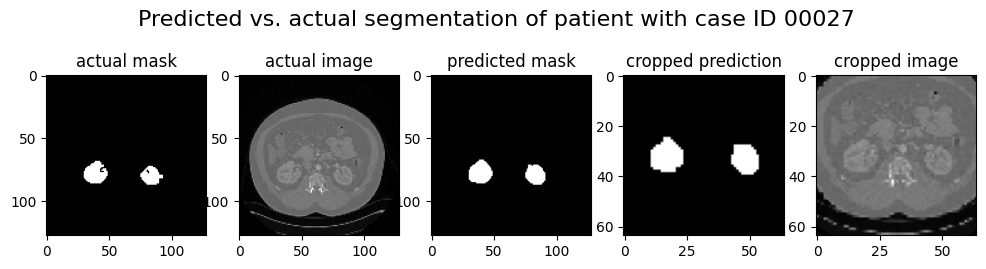

In [333]:
n_img = 27
n_slice = 64
case = all_cases[n_img]

pred_cropped = cropped_predictions[n_img][n_slice,:,:]
cropped_img = cropped_images[n_img][n_slice,:,:]
pred_mask = predictions_output_all[n_img][n_slice,:,:]
test_img = x_all[n_img][n_slice,:,:]
test_mask =  mask_all[n_img][n_slice,:,:]

images = [test_mask, test_img, pred_mask, pred_cropped, cropped_img]


fig = plt.figure(figsize=(12, 3))

# Define row and cols in the figure
rows, cols = 1, 5

titles = ['actual mask', 'actual image', 'predicted mask', 'cropped prediction', 'cropped image']
#titles = ['Cropped pred', 'Cropped img', 'test mask', 'test image']
# Display first four images
for j in range(0, cols*rows):
    fig.add_subplot(rows, cols, j+1)
    plt.title(titles[j])
    plt.imshow(images[j], cmap='gray')

fig.suptitle('Predicted vs. actual segmentation of patient with case ID {0}'.format(case[-5:]), fontsize=16)
plt.show()

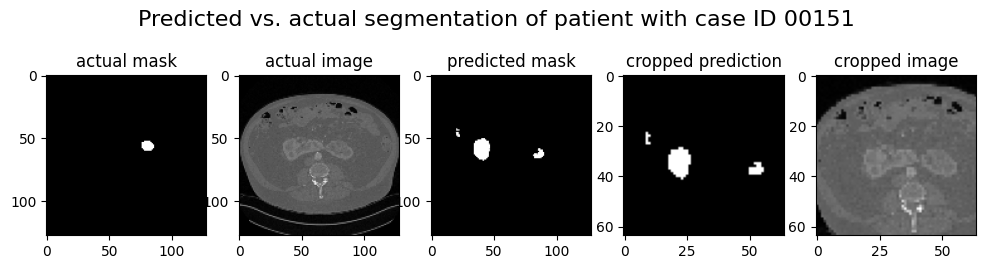

In [349]:
n_img = 151
n_slice = 64
case = all_cases[n_img]

pred_cropped = cropped_predictions[n_img][n_slice, :, :]
cropped_img = cropped_images[n_img][n_slice,:,:]
pred_mask = predictions_output_all[n_img][n_slice,:,:]
test_img = x_all[n_img][n_slice,:,:]
test_mask =  mask_all[n_img][n_slice,:,:]

images = [test_mask, test_img, pred_mask, pred_cropped, cropped_img]


fig = plt.figure(figsize=(12, 3))

# Define row and cols in the figure
rows, cols = 1, 5

titles = ['actual mask', 'actual image', 'predicted mask', 'cropped prediction', 'cropped image']
#titles = ['Cropped pred', 'Cropped img', 'test mask', 'test image']
# Display first four images
for j in range(0, cols*rows):
    fig.add_subplot(rows, cols, j+1)
    plt.title(titles[j])
    plt.imshow(images[j], cmap='gray')

fig.suptitle('Predicted vs. actual segmentation of patient with case ID {0}'.format(case[-5:]), fontsize=16)
plt.show()

In [344]:
print(x_test[15][64][10][10])

tf.Tensor([0.], shape=(1,), dtype=float32)


0.9222 0.9224 0.9233


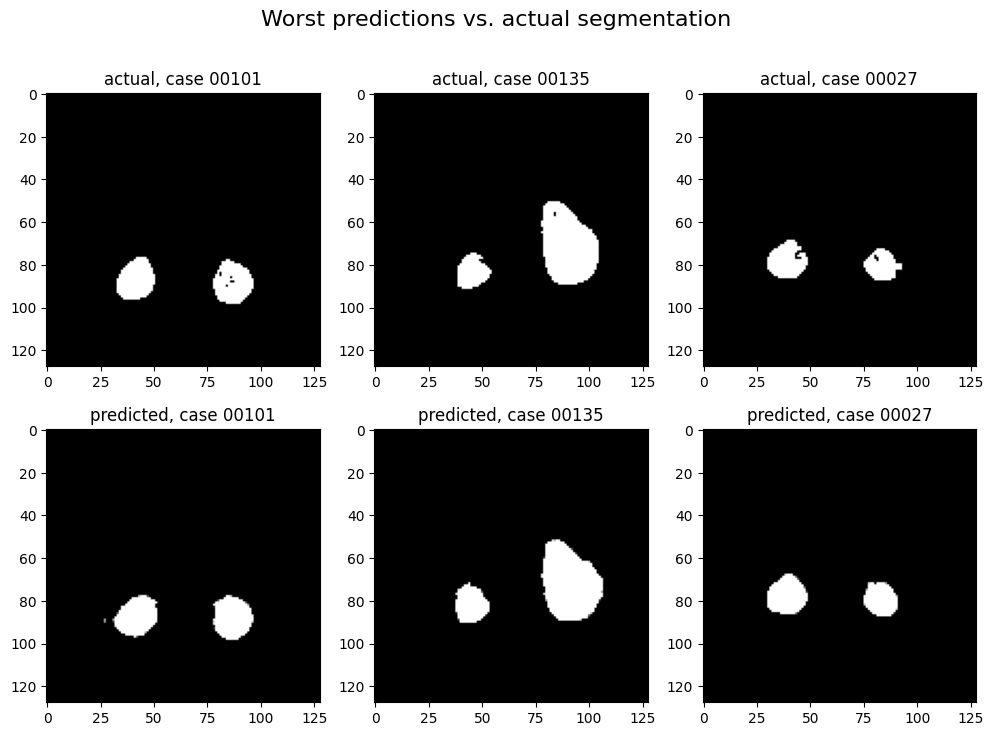

In [339]:
n_slice = 64
N = 3
res = sorted(range(len(dice_scores_all)), key = lambda sub: dice_scores_all[sub])[-3:]
print(dice_scores_all[res[0]], dice_scores_all[res[1]], dice_scores_all[res[2]])
images, scores, cases = [], [], []

images.append(mask_all[res[0]][n_slice,:,:])
images.append(mask_all[res[1]][n_slice,:,:])
images.append(mask_all[res[2]][n_slice,:,:])
cases.append(all_cases[res[0]][-5:]), cases.append(all_cases[res[1]][-5:]), cases.append(all_cases[res[2]][-5:])


images.append(predictions_output_all[res[0]][n_slice,:,:])
images.append(predictions_output_all[res[1]][n_slice,:,:])
images.append(predictions_output_all[res[2]][n_slice,:,:])


#images = [test_binary, pred_binary]
#scores = [score_1]
# Define a figure of size (12, 12)
fig = plt.figure(figsize=(12, 8))

# Define row and cols in the figure
rows, cols = 2, 3

titles = ['actual, case {0}'.format(cases[0]), 'actual, case {0}'.format(cases[1]), 'actual, case {0}'.format(cases[2]), 
          'predicted, case {0}'.format(cases[0]), 'predicted, case {0}'.format(cases[1]), 'predicted, case {0}'.format(cases[2])]
# Display first four images
for j in range(0, cols*rows):
    fig.add_subplot(rows, cols, j+1)
    plt.title(titles[j])
    plt.imshow(images[j], cmap='gray')

fig.suptitle('Worst predictions vs. actual segmentation', fontsize=16)
plt.show()

0.2717 0.3604 0.4226


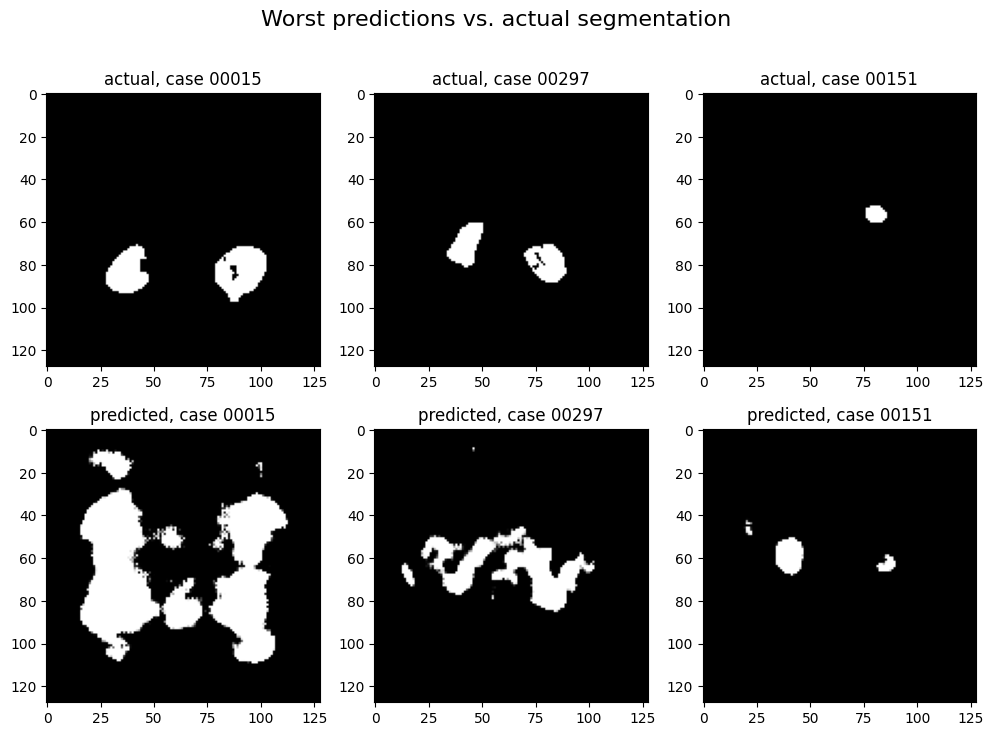

In [338]:
n_slice = 64
N = 3
res = sorted(range(len(dice_scores_all)), key = lambda sub: dice_scores_all[sub])[:3]
print(dice_scores_all[res[0]], dice_scores_all[res[1]], dice_scores_all[res[2]])
images, scores, cases = [], [], []

images.append(mask_all[res[0]][n_slice,:,:])
images.append(mask_all[res[1]][n_slice,:,:])
images.append(mask_all[res[2]][n_slice,:,:])
cases.append(all_cases[res[0]][-5:]), cases.append(all_cases[res[1]][-5:]), cases.append(all_cases[res[2]][-5:])


images.append(predictions_output_all[res[0]][n_slice,:,:])
images.append(predictions_output_all[res[1]][n_slice,:,:])
images.append(predictions_output_all[res[2]][n_slice,:,:])


#images = [test_binary, pred_binary]
#scores = [score_1]
# Define a figure of size (12, 12)
fig = plt.figure(figsize=(12, 8))

# Define row and cols in the figure
rows, cols = 2, 3

titles = ['actual, case {0}'.format(cases[0]), 'actual, case {0}'.format(cases[1]), 'actual, case {0}'.format(cases[2]), 
          'predicted, case {0}'.format(cases[0]), 'predicted, case {0}'.format(cases[1]), 'predicted, case {0}'.format(cases[2])]
# Display first four images
for j in range(0, cols*rows):
    fig.add_subplot(rows, cols, j+1)
    plt.title(titles[j])
    plt.imshow(images[j], cmap='gray')

fig.suptitle('Worst predictions vs. actual segmentation', fontsize=16)
plt.show()

### Check if arrays are saved properly

(115, 128, 128)
[0. 1. 2. 3.]


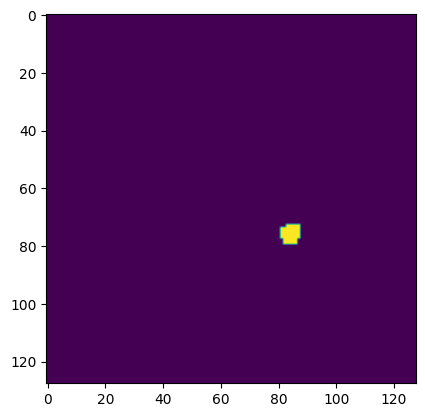

In [281]:
ct_nii = np.load('./preprocessed-data/masks/case_00100.npy')
print(ct_nii.shape)
print(np.unique(ct_nii))
test = ct_nii[5,:,:]
plt.imshow(test)

(328, 128, 128)
[0. 1. 2. 3.]


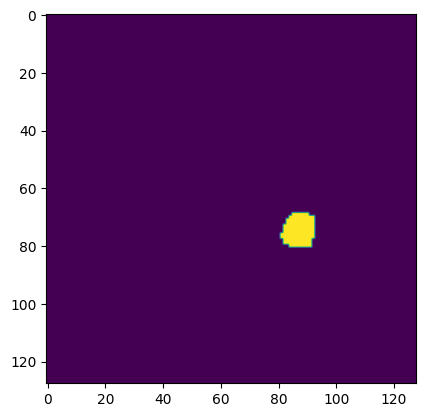

In [359]:
ct_nii = np.load('./preprocessed-data/masks/case_00151.npy')
print(ct_nii.shape)
print(np.unique(ct_nii))
test = ct_nii[35,:,:]
plt.imshow(test)

(128, 64, 64)
[0.00000000e+00 2.52016122e-04 2.68096512e-04 ... 9.97818470e-01
 9.98178482e-01 1.00000000e+00]


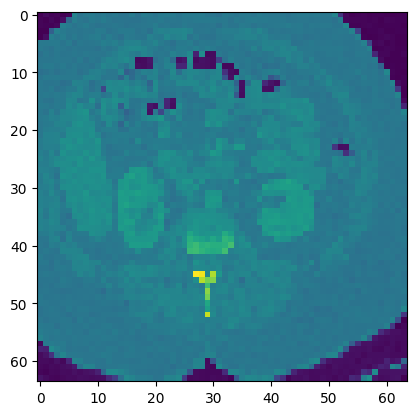

In [284]:
ct_nii = np.load('./cropped-data/images-64/case_00100.npy')
print(ct_nii.shape)
print(np.unique(ct_nii))
test = ct_nii[68,:,:]
plt.imshow(test)

In [ ]:
#Calculating individual dice scores

def dice_coef_multilabel_total(y_true, y_pred, numLabels=4):
    dice=0
    for index in range(y_true.shape[3]):
        subdice = dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
        dice -= dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice.numpy()

def dice_coef_multilabel_individual(y_true, y_pred, numLabels=4):
    dice_list = []
    for index in range(y_true.shape[3]):
        subdice = dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
        subdice = subdice.numpy()
        dice_list.append(subdice)
    return dice_list

In [ ]:
#total_background, total_kidney, total_tumor, total_cyst, diced = 0, 0, 0, 0, 0

#for i in range(batch_size):
#    diced += dice_coef_multilabel_total(test_mask_batch[i], test_pred_batch[i])
#    indiv_dice_lst = dice_coef_multilabel_individual(test_mask_batch[i], test_pred_batch[i])
    #print("individual scores:", indiv_dice_lst)
    
#    total_background += indiv_dice_lst[0]
#    total_kidney += indiv_dice_lst[1]
#    total_tumor += indiv_dice_lst[2]
#    total_cyst += indiv_dice_lst[3]
    

#print("b:", total_background, "k:", total_kidney, "t:", total_tumor, "c:", total_cyst)

##mean_background = total_background/batch_size
#mean_kidney = total_kidney/batch_size
#mean_tumor = total_tumor/batch_size
#mean_cyst = total_cyst/batch_size
#mean_dice = diced/batch_size
#actual_mean_dice = (mean_background+mean_kidney+mean_tumor+mean_cyst)/4
#mean_cyst

#print("mean b:", mean_background, ", mean k:", mean_kidney, ", mean t:", mean_tumor, ", mean c:", mean_cyst)
#print("mean dice: ", mean_dice)
#print("actual mean dice: ", actual_mean_dice)


In [ ]:
#Calculating mean IoU (related to dice)
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4) #one-hot to single channel image
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4) #one-hot to single channel image
print(test_mask_batch.shape, test_mask_batch_argmax.shape, np.unique(test_mask_batch), np.unique(test_mask_batch_argmax))
print(test_pred_batch.shape, test_pred_batch_argmax.shape, np.unique(test_pred_batch), np.unique(test_pred_batch_argmax))


#Verify IoU on a batch of images from the test dataset
n_classes = 1
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())